## Imports

In [1]:
import re
from datetime import timedelta
from os.path import join as opj
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.stats import entropy, pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

## Set paths

In [2]:
datadir = '../../data/'
rawdir = opj(datadir, 'raw')
figdir = '../../figures/'

## Load data

In [3]:
# four forces lecture transcript
with open(opj(rawdir, 'forces_transcript_timestamped.txt'), 'r') as f:
    ff_transcript = f.read()

# birth of stars lecture transcript
with open(opj(rawdir, 'bos_transcript_timestamped.txt'), 'r') as f:
    bos_transcript = f.read()
    
# questions
questions_df = pd.read_csv(opj(rawdir, 'questions.tsv'), sep='\t', 
                           names=['index', 'lecture', 'question', 
                                  'ans_A', 'ans_B', 'ans_C', 'ans_D'], 
                           index_col='index')

# raw scores
scores_df = pd.read_csv(opj(rawdir, 'Graded_results_19f_49.csv'), index_col='Unnamed: 0')

## Set basic params

In [4]:
stop_words = stopwords.words('english') + ["let", "let's", "they'd", "they're", 
                                           "they've", "they'll", "that's", 
                                           "I'll", "I'm"]
cv_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': stop_words
}

lda_params = {
    'max_iter': 10,
    'learning_method': 'batch',
    'random_state': 0
}

## Define some functions

In [5]:
def r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    

def z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    

def corr_mean(rs, axis=0):
    return z2r(np.nanmean([r2z(r) for r in rs], axis=axis))

In [6]:
def format_text(windows, sw=stop_words):
    clean_text = []
    for chunk in windows:
        no_punc = re.sub("[^a-zA-Z\s'-]+", '', chunk.lower()).replace('-', ' ')
        no_stop = ' '.join([word for word in no_punc.split() if word not in sw])
        clean = re.sub("'+", '', no_stop)
        if clean:
            clean_text.append(clean)
    return clean_text

In [7]:
def _ts_to_secs(ts):
    mins, secs = ts.split(':')
    mins, secs = int(mins), int(secs)
    return timedelta(minutes=mins, seconds=secs).total_seconds()
    

def parse_windows(transcript, wsize):
    lines = transcript.splitlines()
    text_lines = [l for ix, l in enumerate(lines) if ix % 2]
    ts_lines = [_ts_to_secs(l) for ix, l in enumerate(lines) if not ix % 2]    
    windows = []
    timestamps = []
    for ix in range(1, wsize):
        start, end = 0, ix
        windows.append(' '.join(text_lines[start : end]))
        timestamps.append((ts_lines[start] + ts_lines[end - 1]) / 2)

    for ix in range(len(ts_lines)):
        start = ix
        end = ix + wsize if ix + wsize <= len(text_lines) else len(text_lines)
        windows.append(' '.join(text_lines[start : end]))
        timestamps.append((ts_lines[start] + ts_lines[end - 1]) / 2)
        
    return windows, timestamps

In [8]:
def create_qa_corpus(df, key):
    grouped = df.groupby('lecture')
    gen_qs, ff_qs, bos_qs = grouped['question'].apply(format_text)
    answers_fmt = grouped['ans_A', 'ans_B', 'ans_C', 'ans_D'].agg(format_text)
    gen_correct, ff_correct, bos_correct = answers_fmt['ans_A']
    gen_ans, ff_ans, bos_ans = answers_fmt.apply(np.concatenate, axis=1).apply(list)
    
    # all formatted text for transforming
    all_text = {
        'ff_qs': ff_qs,
        'bos_qs': bos_qs,
        'gen_qs': gen_qs,
        'ff_ans': ff_ans,
        'bos_ans': bos_ans,
        'gen_ans': gen_ans
    }
    # subset of text used to fit model
    corpus_text = {k: v for k, v in all_text.items()}
    if 'q' in key:
        corpus_text['gen_qs'] = []
        corpus_text['gen_ans'] = []
    elif 'q' not in key.lower():
        corpus_text['ff_qs'] = []
        corpus_text['bos_qs'] = []
        corpus_text['gen_qs'] = []
    
    if 'a' in key:
        corpus_text['ff_ans'] = ff_correct
        corpus_text['bos_ans'] = bos_correct
        if 'Q' in key:
            corpus_text['gen_ans'] = gen_correct
    elif 'a' not in key.lower():
        corpus_text['ff_ans'] = []
        corpus_text['bos_ans'] = []
        corpus_text['gen_ans'] = []
        
    return corpus_text, all_text

In [9]:
def interp_lecture(lec_traj, timestamps):
    new_tpts = np.arange(timestamps[-1])
    interp_func = interp1d(timestamps, lec_traj, axis=0)
    return interp_func(new_tpts)

In [10]:
def model_content(n_top, wsize, corpus):
    # get text windows, timestamps
    ff_windows, ff_timestamps = parse_windows(ff_transcript, wsize)
    bos_windows, bos_timestamps = parse_windows(bos_transcript, wsize)
    
    # format lecture, question, answer text
    ff_lec = format_text(ff_windows)
    bos_lec = format_text(bos_windows)
    corpus_text, all_text = create_qa_corpus(questions_df, corpus)
    corpus_text['ff_lec'] = all_text['ff_lec'] = ff_lec
    corpus_text['bos_lec'] = all_text['bos_lec'] = bos_lec

    # set topic model params
    tm_params = {opt: val for opt, val in lda_params.items()}
    tm_params['n_components'] = n_top
    
    full_corpus = [doc for samples in corpus_text.values() for doc in samples]
    
    vecs = {}
    # fit CountVectorizer model
    tf_vectorizer = CountVectorizer(**cv_params)
    tf_vectorizer.fit(full_corpus)
    vecs['full_corpus'] = tf_vectorizer.transform(full_corpus)
    # transform lectures, questions, answers
    for samples, docs in all_text.items():
        vecs[samples] = tf_vectorizer.transform(docs)
        
    trajs = {}
    # fit LDA model
    topic_model = LatentDirichletAllocation(**tm_params)
    topic_model.fit(vecs['full_corpus'])
    # transform lectures, questions, answers
    for samples, docs in all_text.items():
        trajs[samples] = topic_model.transform(vecs[samples])
            
    # interpolate lectures to 1 sample per second
    trajs['ff_lec'] = interp_lecture(trajs['ff_lec'], ff_timestamps)
    trajs['bos_lec'] = interp_lecture(trajs['bos_lec'], bos_timestamps)

    return trajs

In [11]:
def symmetric_KL(a, b, c=.00000000001):
    return np.divide(entropy(a + c, b + c) + entropy(b + c, a + c), 2)
    
def reconstruct_trace(video_model, questions_model, acc):
    wz = 1 - cdist(video_model, questions_model, metric=symmetric_KL)
    wz -= np.min(wz)
    wz /= np.max(wz)
    a = np.sum(wz, axis=1)
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    ba = np.array(np.divide(b, a), ndmin=2)
    return video_model * ba.T

In [12]:
def score_params(traj_dict, scores):
    ff_lec = traj_dict['ff_lec']
    bos_lec = traj_dict['bos_lec']
    ff_bos_questions = np.concatenate((traj_dict['ff_qs'], traj_dict['bos_qs']))
    ff_bos_scores = scores.loc[scores.video != 0]
    p_wrong = []
    msds = []
    
    for subid in tqdm(ff_bos_scores.participantID.unique(), desc='subjects', leave=False):
        sub_pwrong = []
        sub_msds = []
        for lec_ix, lec in enumerate([ff_lec, bos_lec], start=1):
            sub_scores = ff_bos_scores.loc[(ff_bos_scores.video == lec_ix) 
                                           & (ff_bos_scores.participantID == subid) 
                                           & (ff_bos_scores.set == lec_ix)]
            # compute p_wrong
            sub_acc = list(sub_scores['correct?'])
            sub_pc = sum(sub_acc) / len(sub_acc)
            sub_pwrong.append(1 - sub_pc)
            # reconstruct trace
            sub_qs = sub_scores['qID'] - 1
            q_vecs = ff_bos_questions[sub_qs]
            sub_trace = reconstruct_trace(lec, q_vecs, sub_acc)
            # compute mean squared euclidean distance
            sub_msd = np.mean(np.diag(cdist(lec, sub_trace)) ** 2)
            sub_msds.append(sub_msd)
        p_wrong.append(np.mean(sub_pwrong))
        msds.append(np.mean(sub_msds))
            
    return pearsonr(p_wrong, msds)[0]

In [13]:
def grid_search(gs_params):
    n_top, wsize, corpus = gs_params
    trajs = model_content(n_top, wsize, corpus)
    corr = score_params(trajs, scores_df)
    print(f'\t{gs_params} : {corr}')
    return corr

## Grid search params

In [14]:
# (maximum) number of topics to fit the topic model
n_topics = [5, 10, 15, 20, 25, 50, 100]
# length of lecture transcript sliding window
lecture_wsize = [2, 5, 10, 15, 20, 25]
# training corpus for topic model
# - l: lecture sliding windows
# - q: lecture-related multiple choice questions' text
# - Q: all multiple choice questions' text
# - a: correct responses to multiple choice questions
# - A: all options for responses to multiple choice questions
corpora = ['l', 'lq', 'lQ', 'lqa', 'lQa', 'lqA', 'lQA']

param_grid = [(t, w, c) for t in n_topics for w in lecture_wsize for c in corpora]

In [15]:
param_scores = []
for params in tqdm(param_grid, desc='params', leave=True):
    result = grid_search(params)
    param_scores.append(result)

	(5, 2, 'l') : 0.9364615324822911


	(5, 2, 'lq') : 0.944970250746461


	(5, 2, 'lQ') : 0.9340308872095071


	(5, 2, 'lqa') : 0.9397073344172859


	(5, 2, 'lQa') : 0.9423709177190387


	(5, 2, 'lqA') : 0.9350716698665255


	(5, 2, 'lQA') : 0.928950825324325


	(5, 5, 'l') : 0.9301882619765177


	(5, 5, 'lq') : 0.9442922934907804


	(5, 5, 'lQ') : 0.9358652773315075


	(5, 5, 'lqa') : 0.9379700593459712


	(5, 5, 'lQa') : 0.9490982989879234


	(5, 5, 'lqA') : 0.9231000400305635


	(5, 5, 'lQA') : 0.9312581580726426


	(5, 10, 'l') : 0.9410724994988767


	(5, 10, 'lq') : 0.9474242501788184


	(5, 10, 'lQ') : 0.9261207395487869


	(5, 10, 'lqa') : 0.9343769453459267


	(5, 10, 'lQa') : 0.9224016526243152


	(5, 10, 'lqA') : 0.9359162958588648


	(5, 10, 'lQA') : 0.9349498565269972


	(5, 15, 'l') : 0.9354216162840069


	(5, 15, 'lq') : 0.9410464644527345


	(5, 15, 'lQ') : 0.9153727602807666


	(5, 15, 'lqa') : 0.9206431584293806


	(5, 15, 'lQa') : 0.940097159987542


	(5, 15, 'lqA') : 0.9318606193436387


	(5, 15, 'lQA') : 0.9424159024061196


	(5, 20, 'l') : 0.9341631757891107


	(5, 20, 'lq') : 0.9469662291102784


	(5, 20, 'lQ') : 0.9253723902621975


	(5, 20, 'lqa') : 0.9296864232012669


	(5, 20, 'lQa') : 0.9324386517533403


	(5, 20, 'lqA') : 0.9410946124254683


	(5, 20, 'lQA') : 0.926894192293527


	(5, 25, 'l') : 0.9311926397519616


	(5, 25, 'lq') : 0.9539751594365261


	(5, 25, 'lQ') : 0.9295626131579572


	(5, 25, 'lqa') : 0.9308635223504005


	(5, 25, 'lQa') : 0.9481416797811374


	(5, 25, 'lqA') : 0.9451337743955989


	(5, 25, 'lQA') : 0.9443242577921935


	(10, 2, 'l') : 0.9288632549355202


	(10, 2, 'lq') : 0.9258710644613043


	(10, 2, 'lQ') : 0.9284352676155743


	(10, 2, 'lqa') : 0.9493353366041464


	(10, 2, 'lQa') : 0.9145607258967351


	(10, 2, 'lqA') : 0.9189040591553114


	(10, 2, 'lQA') : 0.9463470091926839


	(10, 5, 'l') : 0.9165906306512365


	(10, 5, 'lq') : 0.9338701037676751


	(10, 5, 'lQ') : 0.9464427736487206


	(10, 5, 'lqa') : 0.9436322050511278


	(10, 5, 'lQa') : 0.9442519702456522


	(10, 5, 'lqA') : 0.918862647787924


	(10, 5, 'lQA') : 0.9202303577423975


	(10, 10, 'l') : 0.9202402591574185


	(10, 10, 'lq') : 0.9373049369107894


	(10, 10, 'lQ') : 0.9353098215498477


	(10, 10, 'lqa') : 0.9280270536334794


	(10, 10, 'lQa') : 0.925471919970286


	(10, 10, 'lqA') : 0.9282973284817713


	(10, 10, 'lQA') : 0.928805179829213


	(10, 15, 'l') : 0.9390648184295479


	(10, 15, 'lq') : 0.9448620536475937


	(10, 15, 'lQ') : 0.936488989944213


	(10, 15, 'lqa') : 0.9295096600459142


	(10, 15, 'lQa') : 0.9413436733569355


	(10, 15, 'lqA') : 0.9409040367444603


	(10, 15, 'lQA') : 0.9179906325514333


	(10, 20, 'l') : 0.9063908027858889


	(10, 20, 'lq') : 0.9420159326713604


	(10, 20, 'lQ') : 0.9321302689899137


	(10, 20, 'lqa') : 0.9509753149768827


	(10, 20, 'lQa') : 0.935814903711425


	(10, 20, 'lqA') : 0.9340316632243554


	(10, 20, 'lQA') : 0.9392979129926211


	(10, 25, 'l') : 0.9201774428781275


	(10, 25, 'lq') : 0.9395851263898173


	(10, 25, 'lQ') : 0.9273221724146702


	(10, 25, 'lqa') : 0.9288661450297974


	(10, 25, 'lQa') : 0.9323816941527564


	(10, 25, 'lqA') : 0.926663461274959


	(10, 25, 'lQA') : 0.9278782410808968


	(15, 2, 'l') : 0.936974389552881


	(15, 2, 'lq') : 0.932376496804608


	(15, 2, 'lQ') : 0.9365949079208694


	(15, 2, 'lqa') : 0.9308895709966782


	(15, 2, 'lQa') : 0.9334136008224386


	(15, 2, 'lqA') : 0.9318244979201366


	(15, 2, 'lQA') : 0.9398076099989406


	(15, 5, 'l') : 0.9338778833263528


	(15, 5, 'lq') : 0.9384197058220295


	(15, 5, 'lQ') : 0.9238149931429356


	(15, 5, 'lqa') : 0.9438332396158441


	(15, 5, 'lQa') : 0.9246402558237486


	(15, 5, 'lqA') : 0.9301699486844652


	(15, 5, 'lQA') : 0.9368751405164021


	(15, 10, 'l') : 0.9380863219670159


	(15, 10, 'lq') : 0.931771168953215


	(15, 10, 'lQ') : 0.9419232538697714


	(15, 10, 'lqa') : 0.9381030959466761


	(15, 10, 'lQa') : 0.9159735329702992


	(15, 10, 'lqA') : 0.9385536723510353


	(15, 10, 'lQA') : 0.9259351297859129


	(15, 15, 'l') : 0.9254627214366172


	(15, 15, 'lq') : 0.9341477006296302


	(15, 15, 'lQ') : 0.9472574204377564


	(15, 15, 'lqa') : 0.9437348046478549


	(15, 15, 'lQa') : 0.9309681899268044


	(15, 15, 'lqA') : 0.9390760106171243


	(15, 15, 'lQA') : 0.9386975078068637


	(15, 20, 'l') : 0.9278803866799302


	(15, 20, 'lq') : 0.9314893306111952


	(15, 20, 'lQ') : 0.9440000083478556


	(15, 20, 'lqa') : 0.9555142166150223


	(15, 20, 'lQa') : 0.9325205785291265


	(15, 20, 'lqA') : 0.9178270157439583


	(15, 20, 'lQA') : 0.9271099710986666


	(15, 25, 'l') : 0.9338197076101165


	(15, 25, 'lq') : 0.9279875841341746


	(15, 25, 'lQ') : 0.9289252218170557


	(15, 25, 'lqa') : 0.9479252808162003


	(15, 25, 'lQa') : 0.9336774319137826


	(15, 25, 'lqA') : 0.9266651163200077


	(15, 25, 'lQA') : 0.9097468368359336


	(20, 2, 'l') : 0.9295737390143786


	(20, 2, 'lq') : 0.919121031348202


	(20, 2, 'lQ') : 0.917353678342324


	(20, 2, 'lqa') : 0.9106960970540336


	(20, 2, 'lQa') : 0.9337994044163903


	(20, 2, 'lqA') : 0.9212453752700629


	(20, 2, 'lQA') : 0.9290830650017443


	(20, 5, 'l') : 0.9375911796511726


	(20, 5, 'lq') : 0.9283390350014743


	(20, 5, 'lQ') : 0.9192369367222777


	(20, 5, 'lqa') : 0.9494528764035662


	(20, 5, 'lQa') : 0.9332803113704063


	(20, 5, 'lqA') : 0.9253968149544679


	(20, 5, 'lQA') : 0.9470197416442203


	(20, 10, 'l') : 0.9339576959884057


	(20, 10, 'lq') : 0.9297737424631461


	(20, 10, 'lQ') : 0.9116370442226571


	(20, 10, 'lqa') : 0.9467360726423795


	(20, 10, 'lQa') : 0.9439453970853601


	(20, 10, 'lqA') : 0.9305476924930657


	(20, 10, 'lQA') : 0.9301343263485728


	(20, 15, 'l') : 0.924379570829712


	(20, 15, 'lq') : 0.9302992158810833


	(20, 15, 'lQ') : 0.9332015047884291


	(20, 15, 'lqa') : 0.9348922678091199


	(20, 15, 'lQa') : 0.958101258428538


	(20, 15, 'lqA') : 0.9414859233914918


	(20, 15, 'lQA') : 0.8993031731743863


	(20, 20, 'l') : 0.9323386818139733


	(20, 20, 'lq') : 0.9303672104160161


	(20, 20, 'lQ') : 0.931634237811862


	(20, 20, 'lqa') : 0.9143992272386069


	(20, 20, 'lQa') : 0.932341903018378


	(20, 20, 'lqA') : 0.9286887608048608


	(20, 20, 'lQA') : 0.9376076895094125


	(20, 25, 'l') : 0.9257514410146706


	(20, 25, 'lq') : 0.9417807780726577


	(20, 25, 'lQ') : 0.9345458223750153


	(20, 25, 'lqa') : 0.9312631447922993


	(20, 25, 'lQa') : 0.9387892320457403


	(20, 25, 'lqA') : 0.9240853118922735


	(20, 25, 'lQA') : 0.9455203682062805


	(25, 2, 'l') : 0.9368829007174615


	(25, 2, 'lq') : 0.9296305374667626


	(25, 2, 'lQ') : 0.9248381675115368


	(25, 2, 'lqa') : 0.9181729090775443


	(25, 2, 'lQa') : 0.9138021283524757


	(25, 2, 'lqA') : 0.927474825290035


	(25, 2, 'lQA') : 0.920575990247396


	(25, 5, 'l') : 0.9233070122508413


	(25, 5, 'lq') : 0.9398146221809901


	(25, 5, 'lQ') : 0.9341864812403713


	(25, 5, 'lqa') : 0.9186989556676368


	(25, 5, 'lQa') : 0.9261533077084014


	(25, 5, 'lqA') : 0.9240661535407608


	(25, 5, 'lQA') : 0.935636196910055


	(25, 10, 'l') : 0.9226536300799859


	(25, 10, 'lq') : 0.918747852153152


	(25, 10, 'lQ') : 0.9308743218680489


	(25, 10, 'lqa') : 0.9445622610756181


	(25, 10, 'lQa') : 0.9383180675472655


	(25, 10, 'lqA') : 0.9399788896291454


	(25, 10, 'lQA') : 0.9333111891300113


	(25, 15, 'l') : 0.9356552977151772


	(25, 15, 'lq') : 0.9276993858173791


	(25, 15, 'lQ') : 0.9418349754868324


	(25, 15, 'lqa') : 0.9314604475067075


	(25, 15, 'lQa') : 0.9431627363587652


	(25, 15, 'lqA') : 0.9310572763985596


	(25, 15, 'lQA') : 0.9283073120494684


	(25, 20, 'l') : 0.9221008739669967


	(25, 20, 'lq') : 0.943463733299095


	(25, 20, 'lQ') : 0.9420677992775418


	(25, 20, 'lqa') : 0.9356694695687309


	(25, 20, 'lQa') : 0.9142493620671678


	(25, 20, 'lqA') : 0.9258852191348264


	(25, 20, 'lQA') : 0.9463536727252702


	(25, 25, 'l') : 0.9225080873500376


	(25, 25, 'lq') : 0.9314911717099528


	(25, 25, 'lQ') : 0.9467852861295303


	(25, 25, 'lqa') : 0.9359641570508316


	(25, 25, 'lQa') : 0.9119267175030629


	(25, 25, 'lqA') : 0.9358231950133249


	(25, 25, 'lQA') : 0.9262435141031178


	(50, 2, 'l') : 0.9267689497200196


	(50, 2, 'lq') : 0.9056886871192126


	(50, 2, 'lQ') : 0.9226967560582561


	(50, 2, 'lqa') : 0.9211568315826246


	(50, 2, 'lQa') : 0.9329131543708272


	(50, 2, 'lqA') : 0.9302626501049135


	(50, 2, 'lQA') : 0.9092083642669603


	(50, 5, 'l') : 0.9173318285812613


	(50, 5, 'lq') : 0.9338789586715459


	(50, 5, 'lQ') : 0.891303237844005


	(50, 5, 'lqa') : 0.9151944908049315


	(50, 5, 'lQa') : 0.9312286460480509


	(50, 5, 'lqA') : 0.9205519160697924


	(50, 5, 'lQA') : 0.9358867960548092


	(50, 10, 'l') : 0.9224754901974851


	(50, 10, 'lq') : 0.9350468577052443


	(50, 10, 'lQ') : 0.9110672550377402


	(50, 10, 'lqa') : 0.9176420645115684


	(50, 10, 'lQa') : 0.9263452180685998


	(50, 10, 'lqA') : 0.9209294093285747


	(50, 10, 'lQA') : 0.919484586249644


	(50, 15, 'l') : 0.9153436963687009


	(50, 15, 'lq') : 0.9096424070779566


	(50, 15, 'lQ') : 0.9132194052614145


	(50, 15, 'lqa') : 0.931657631771494


	(50, 15, 'lQa') : 0.903757102212252


	(50, 15, 'lqA') : 0.9450275046151617


	(50, 15, 'lQA') : 0.8971026119237585


	(50, 20, 'l') : 0.9171040746793115


	(50, 20, 'lq') : 0.9243116926307909


	(50, 20, 'lQ') : 0.9226753574060034


	(50, 20, 'lqa') : 0.8640268587723137


	(50, 20, 'lQa') : 0.9087319582480992


	(50, 20, 'lqA') : 0.9199148825948904


	(50, 20, 'lQA') : 0.8798452179739988


	(50, 25, 'l') : 0.9271451534391112


	(50, 25, 'lq') : 0.9259937826311228


	(50, 25, 'lQ') : 0.9103724530207953


	(50, 25, 'lqa') : 0.9056203122564738


	(50, 25, 'lQa') : 0.9173472166671643


	(50, 25, 'lqA') : 0.9176771814853473


	(50, 25, 'lQA') : 0.9162898818398456


	(100, 2, 'l') : 0.923108983046915


	(100, 2, 'lq') : 0.9127753668160531


	(100, 2, 'lQ') : 0.9052804569542174


	(100, 2, 'lqa') : 0.9088430958875519


	(100, 2, 'lQa') : 0.8955605274735231


	(100, 2, 'lqA') : 0.9137172537315086


	(100, 2, 'lQA') : 0.9172912195064878


	(100, 5, 'l') : 0.920513772996372


	(100, 5, 'lq') : 0.9136150316728747


	(100, 5, 'lQ') : 0.9049684857276341


	(100, 5, 'lqa') : 0.9152070008951033


	(100, 5, 'lQa') : 0.9157671877177735


	(100, 5, 'lqA') : 0.9128296111320844


	(100, 5, 'lQA') : 0.8962620440404988


	(100, 10, 'l') : 0.9134772129121478


	(100, 10, 'lq') : 0.8842348846356716


	(100, 10, 'lQ') : 0.9089864129079037


	(100, 10, 'lqa') : 0.9233218641075333


	(100, 10, 'lQa') : 0.9107891118140541


	(100, 10, 'lqA') : 0.922313650925692


	(100, 10, 'lQA') : 0.9214966601191743


	(100, 15, 'l') : 0.9058293083249629


	(100, 15, 'lq') : 0.8859639775925601


	(100, 15, 'lQ') : 0.8971238727247783


	(100, 15, 'lqa') : 0.9087773983443418


	(100, 15, 'lQa') : 0.9109888964492503


	(100, 15, 'lqA') : 0.9044215564857802


	(100, 15, 'lQA') : 0.9082691828763085


	(100, 20, 'l') : 0.9006177308827689


	(100, 20, 'lq') : 0.874014781200283


	(100, 20, 'lQ') : 0.9082601874213033


	(100, 20, 'lqa') : 0.8997685273028168


	(100, 20, 'lQa') : 0.8945758004265164


	(100, 20, 'lqA') : 0.9081767183861528


	(100, 20, 'lQA') : 0.9147963209498438


	(100, 25, 'l') : 0.9097864099064352


	(100, 25, 'lq') : 0.8846411352620419


	(100, 25, 'lQ') : 0.8951101800103084


	(100, 25, 'lqa') : 0.9230413263919803


	(100, 25, 'lQa') : 0.8876916327188604


	(100, 25, 'lqA') : 0.9338994549920236


	(100, 25, 'lQA') : 0.8974984211932467



In [16]:
np.array(param_grid)[np.argmax(param_scores)]

array(['20', '15', 'lQa'], dtype='<U21')

In [52]:
gs_results = pd.DataFrame(param_grid, columns=['topics', 'wsize', 'corpus'])
gs_results['correlation'] = param_scores
gs_results.to_pickle(opj(datadir, 'grid_search_results.p'))

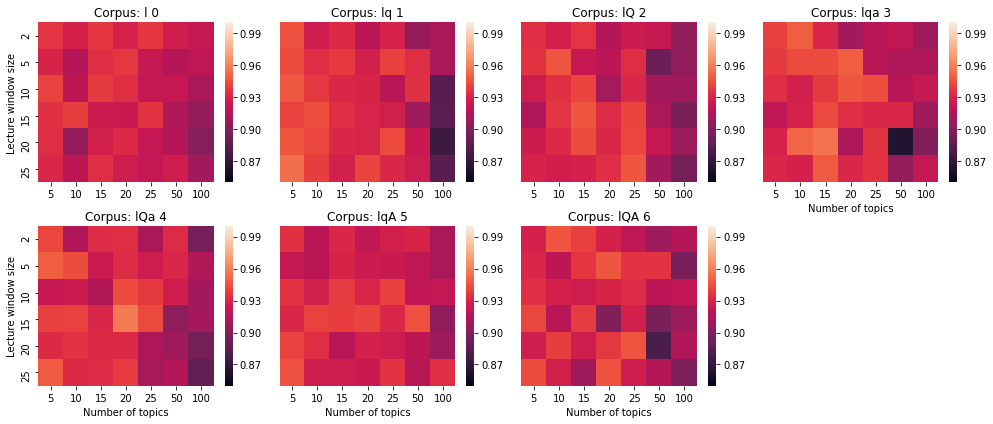

In [51]:
fig, axarr = plt.subplots(2, 4)
fig.set_size_inches(14, 6)
axarr = axarr.flatten()

param_arr = np.array(param_scores).reshape(7, 6, 7)

for i, (ax, arr) in enumerate(zip(axarr, param_arr.T)):
    cb = True
    yt = lecture_wsize if i in [0, 4] else []
    ax = sns.heatmap(arr, vmin=.85, vmax=1, xticklabels=n_topics, yticklabels=yt, ax=ax, cbar=cb)
    ax.set_title(f'Corpus: {corpora[i]} {i}')
    if i >= 3:
        ax.set_xlabel('Number of topics')
    if i in [0, 4]:
        ax.set_ylabel('Lecture window size')
    
axarr[-1].axis('off')
plt.tight_layout()
plt.show()